# Example

In [99]:
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 1337
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

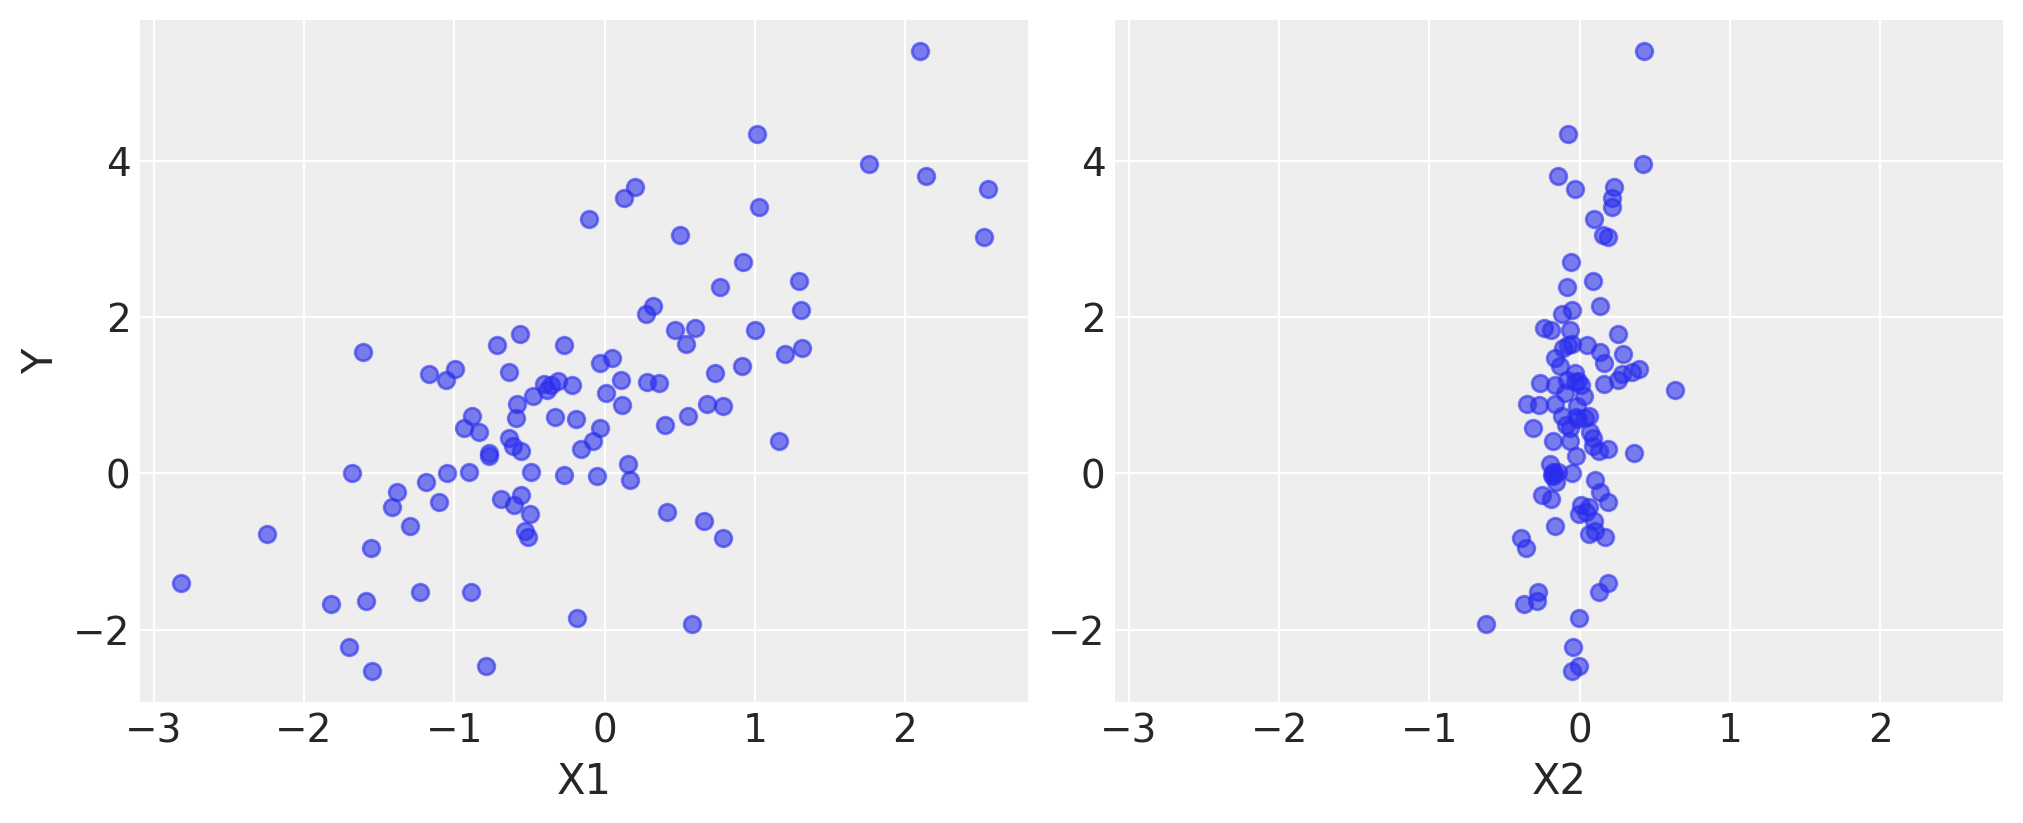

In [5]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [6]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.8.0


In [9]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [10]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 136 seconds.


In [11]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [12]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[0.89103151, 1.06114388, 1.05908679, 0.96011848, 0.94740304],
       [1.08221678, 1.08221678, 0.95719032, 0.90638625, 0.91449501],
       [0.88826312, 0.89157261, 0.96466878, 1.145081  , 0.92989234],
       [0.81634867, 0.8861179 , 0.76237683, 1.10164132, 1.04022351]])
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4

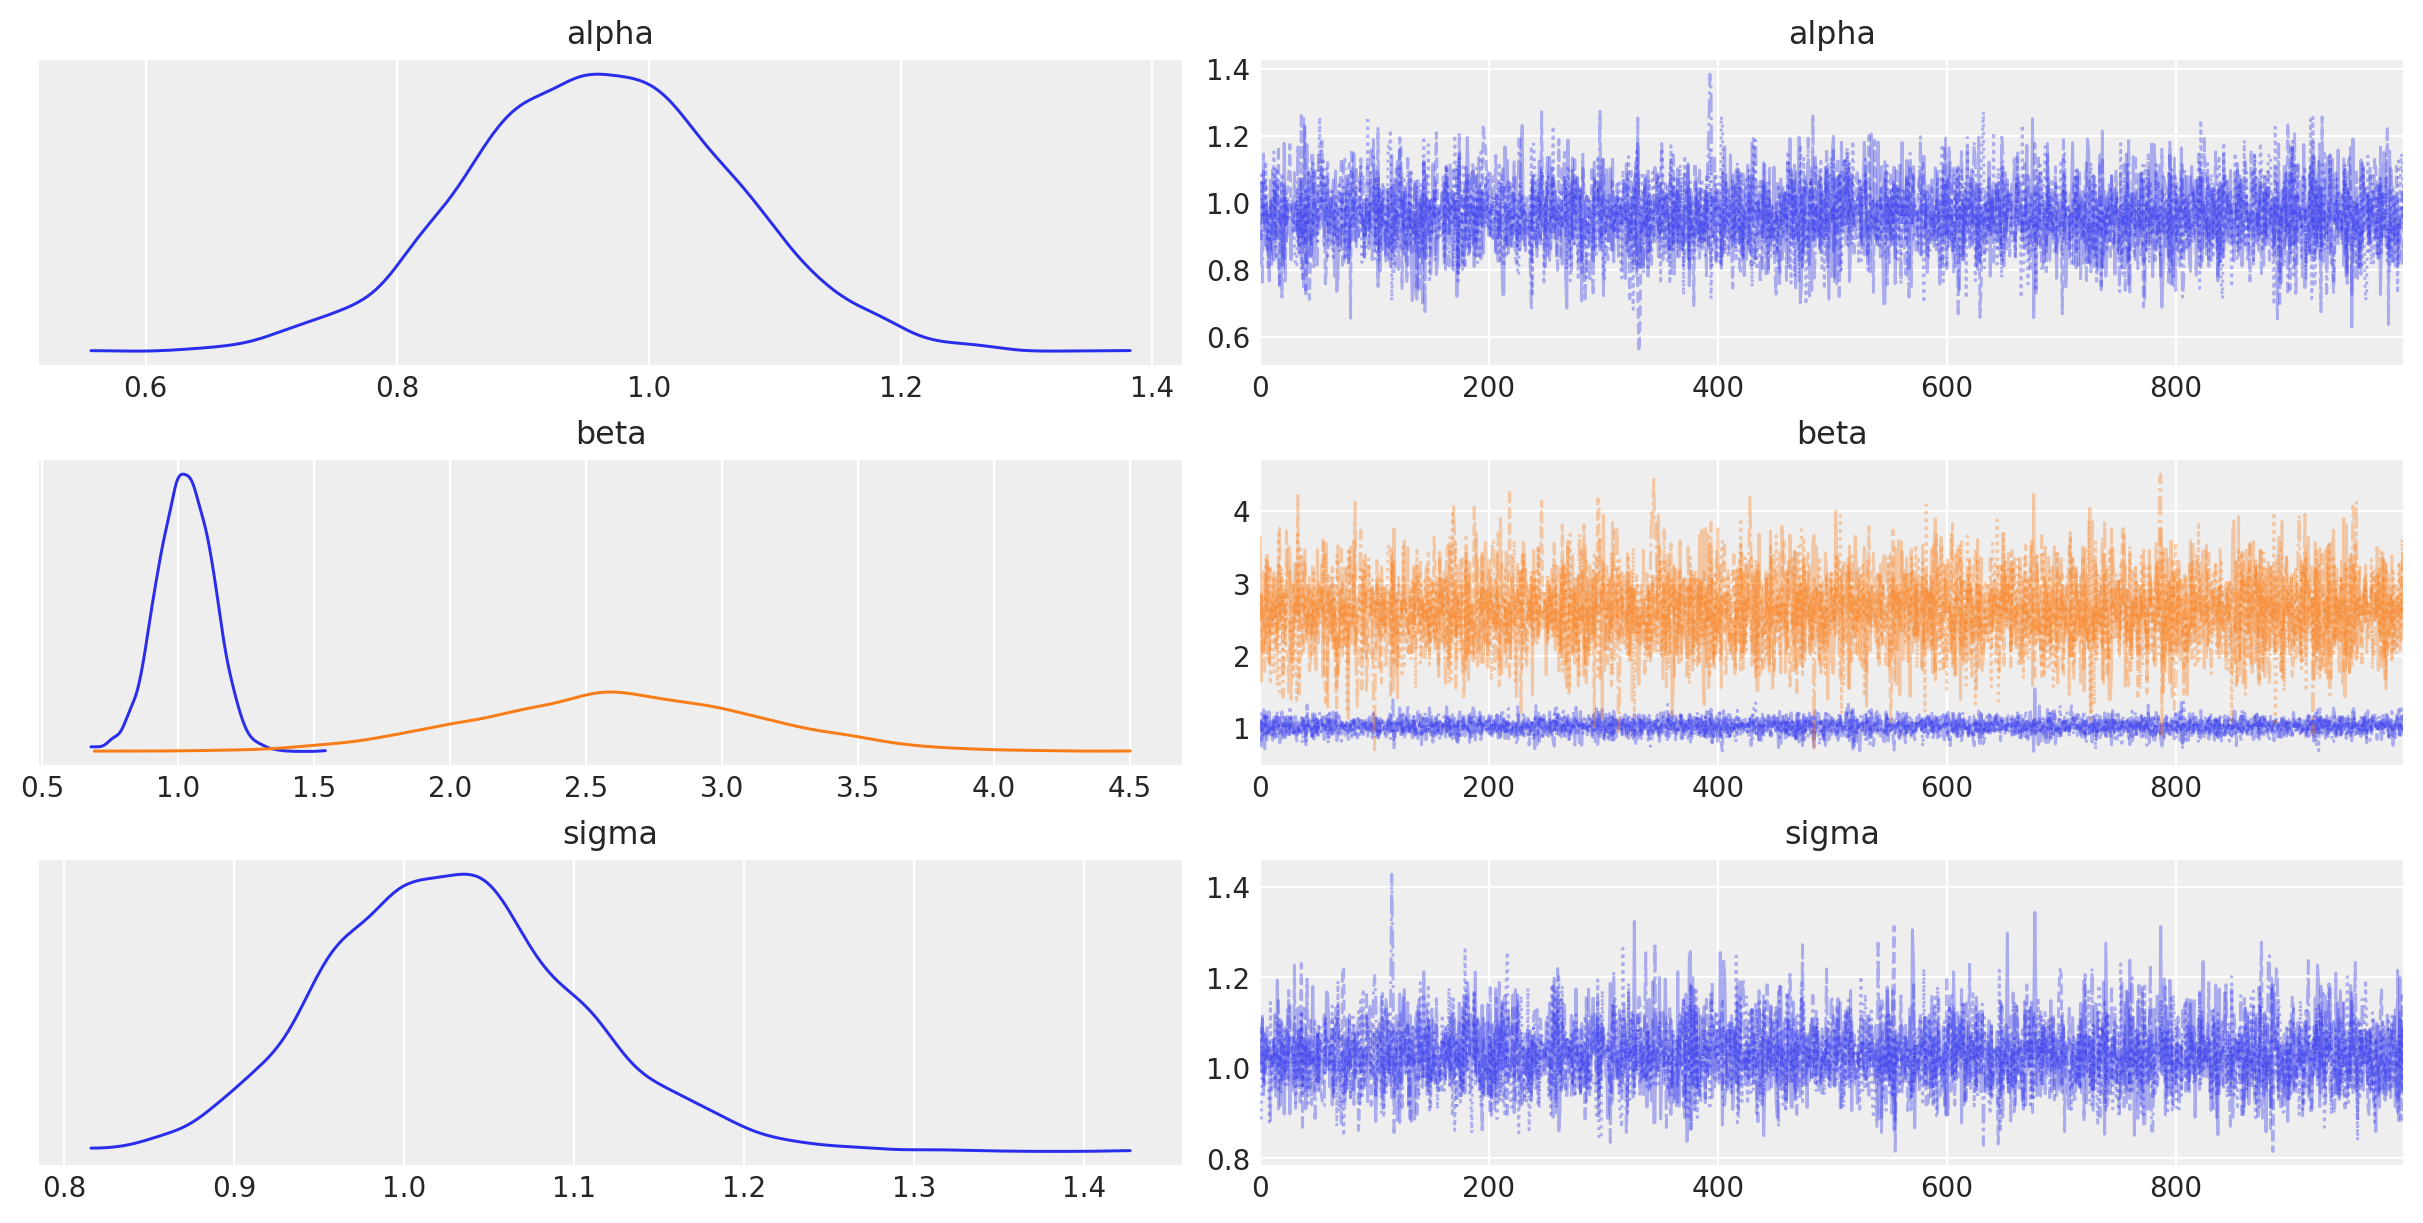

In [13]:
az.plot_trace(idata, combined=True)

In [14]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.96,0.10,0.76,1.15,0.00,0.0,5608.55,3372.24,1.0
beta[0],1.03,0.10,0.83,1.21,0.00,0.0,6526.26,3019.81,1.0
beta[1],2.62,0.52,1.66,3.59,0.01,0.0,6008.98,3160.29,1.0
sigma,1.03,0.07,0.89,1.16,0.00,0.0,5499.47,3226.34,1.0


# Fish Market Dataset

In [145]:
# read data from github
df = pd.read_csv('https://raw.githubusercontent.com/Ankit152/Fish-Market/main/Fish.csv')

# remove from the dataset
df = df[df['Weight'] != 0]

# only keep correlated features
df = df[["Weight", "Length1", "Height"]]

# log transform the columns
df["Length1"] = np.log10(df["Length1"])  # Base 10 logarithm
df["Height"] = np.log10(df["Height"])    # Base 10 logarithm
df["Weight"] = np.log10(df["Weight"])    # Base 10 logarithm

# split
X, y = df[["Length1", "Height"]], df[["Weight"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)

df.head()

,Weight,Length1,Height
0,2.383815,1.365488,1.061452
1,2.462398,1.380211,1.096215
2,2.531479,1.378398,1.092643
3,2.559907,1.419956,1.104828
4,2.633468,1.423246,1.094960


C:\Users\10122055\AppData\Local\pypoetry\Cache\virtualenvs\bayesianstatistics-JxD27Ns--py3.10\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\10122055\AppData\Local\pypoetry\Cache\virtualenvs\bayesianstatistics-JxD27Ns--py3.10\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\10122055\AppData\Local\pypoetry\Cache\virtualenvs\bayesianstatistics-JxD27Ns--py3.10\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\10122055\AppData

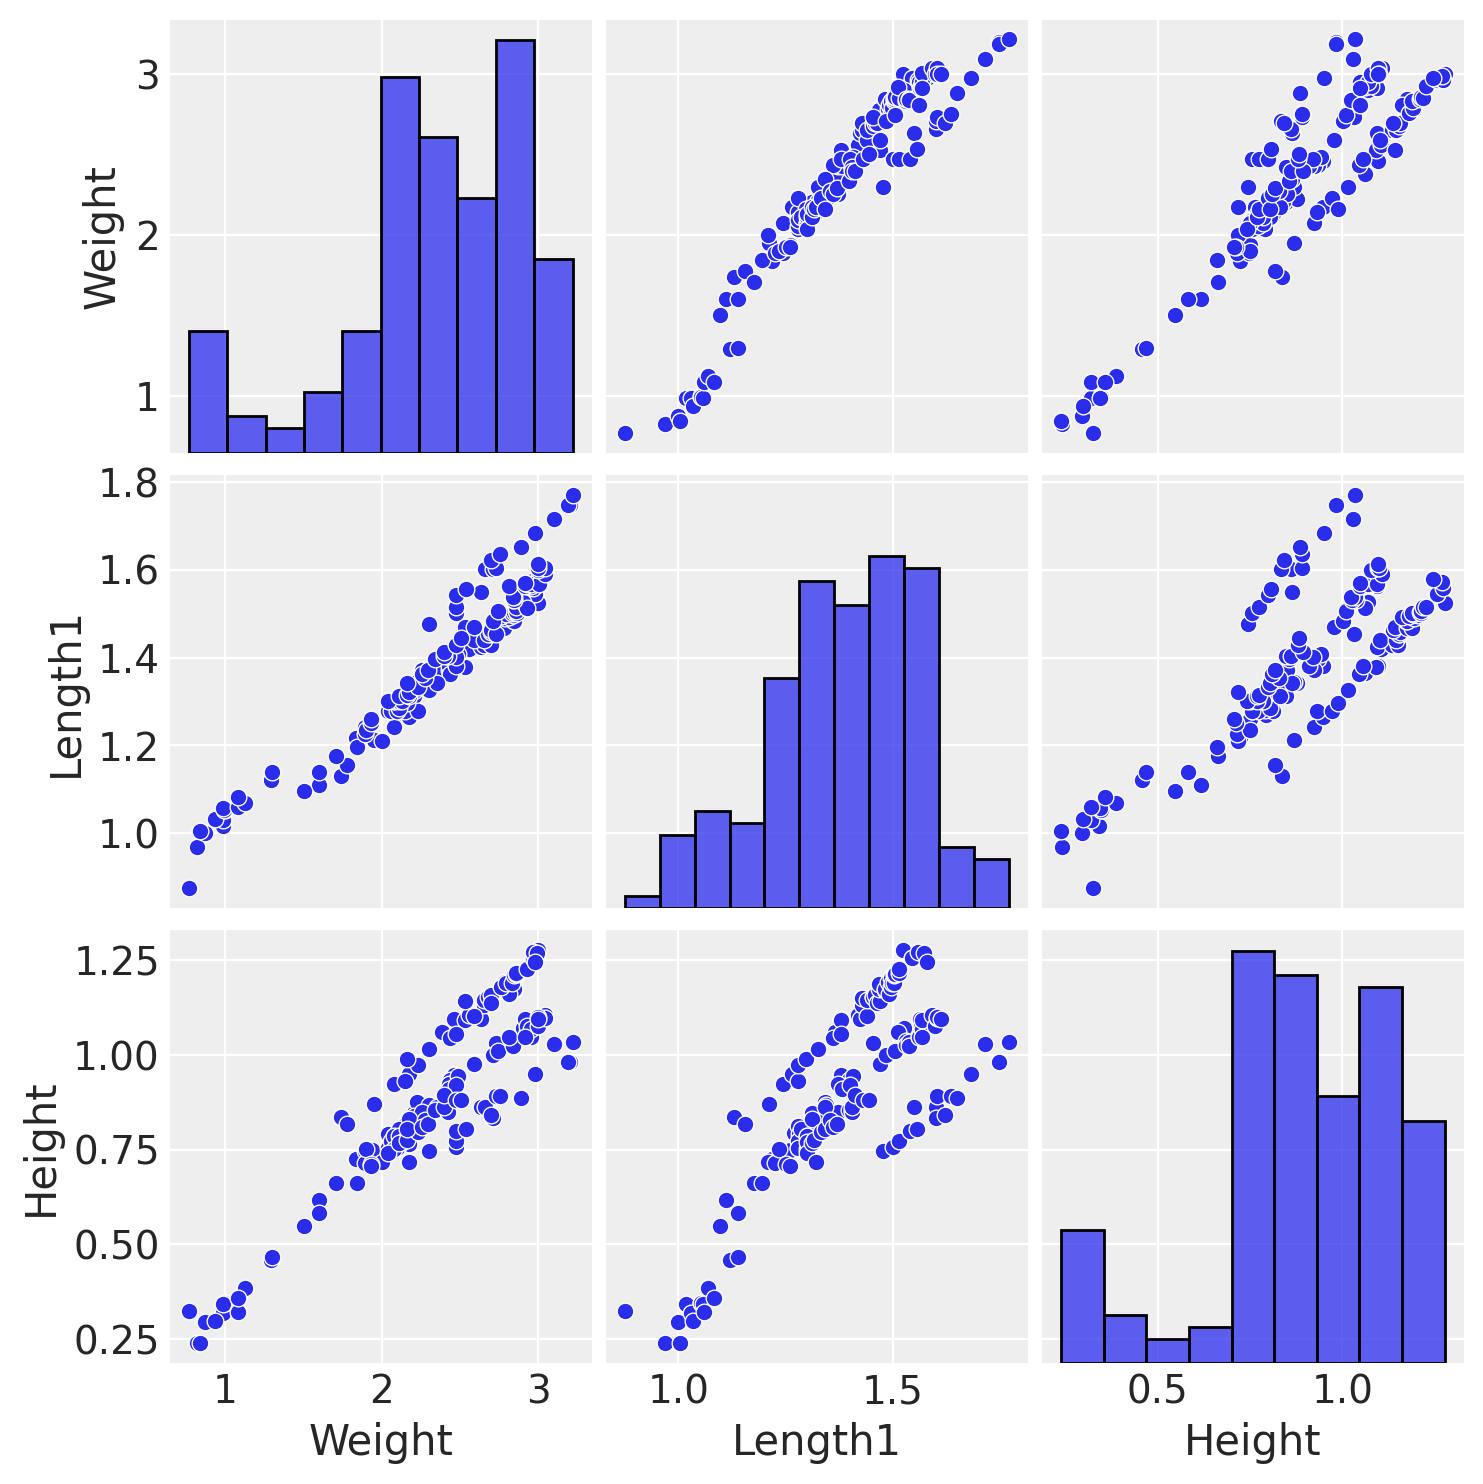

In [33]:
# pairplot
sns.pairplot(data = df)

In [146]:
model = pm.Model()

Weight = y_train['Weight'].to_numpy()
Length1 = X_train['Length1'].to_numpy()
Height = X_train['Height'].to_numpy()

with model:
    Weight_ = pm.MutableData("Weight", Weight)
    Length1_ = pm.MutableData("Length1", Length1)
    Height_ = pm.MutableData("Height", Height)

    β0 = pm.Normal("β0", mu=-1.5, sigma=0.06)
    β1 = pm.Normal("β1", mu=2, sigma=0.06)
    β2 = pm.Normal("β2", mu=1, sigma=0.04)
    sigma = pm.HalfNormal("σ", sigma=0.07)

    mu = β0 + β1 * Length1 + β2 * Height
    pm.Normal("Weight_pred", mu=mu, sigma=sigma, observed=Weight_, shape=mu.shape)

#pm.model_to_graphviz(model)

with model:
    idata = pm.sample(1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, β2, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 732 seconds.


In [147]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β0,-1.39,0.03,-1.46,-1.33,0.0,0.0,2185.94,2107.49,1.0
β1,2.07,0.03,2.01,2.13,0.0,0.0,1835.91,1617.98,1.0
β2,0.98,0.03,0.93,1.03,0.0,0.0,2134.60,1970.85,1.0
σ,0.07,0.00,0.06,0.07,0.0,0.0,2692.24,2041.05,1.0


array([[<Axes: title={'center': 'β0'}>, <Axes: title={'center': 'β0'}>],
       [<Axes: title={'center': 'β1'}>, <Axes: title={'center': 'β1'}>],
       [<Axes: title={'center': 'β2'}>, <Axes: title={'center': 'β2'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

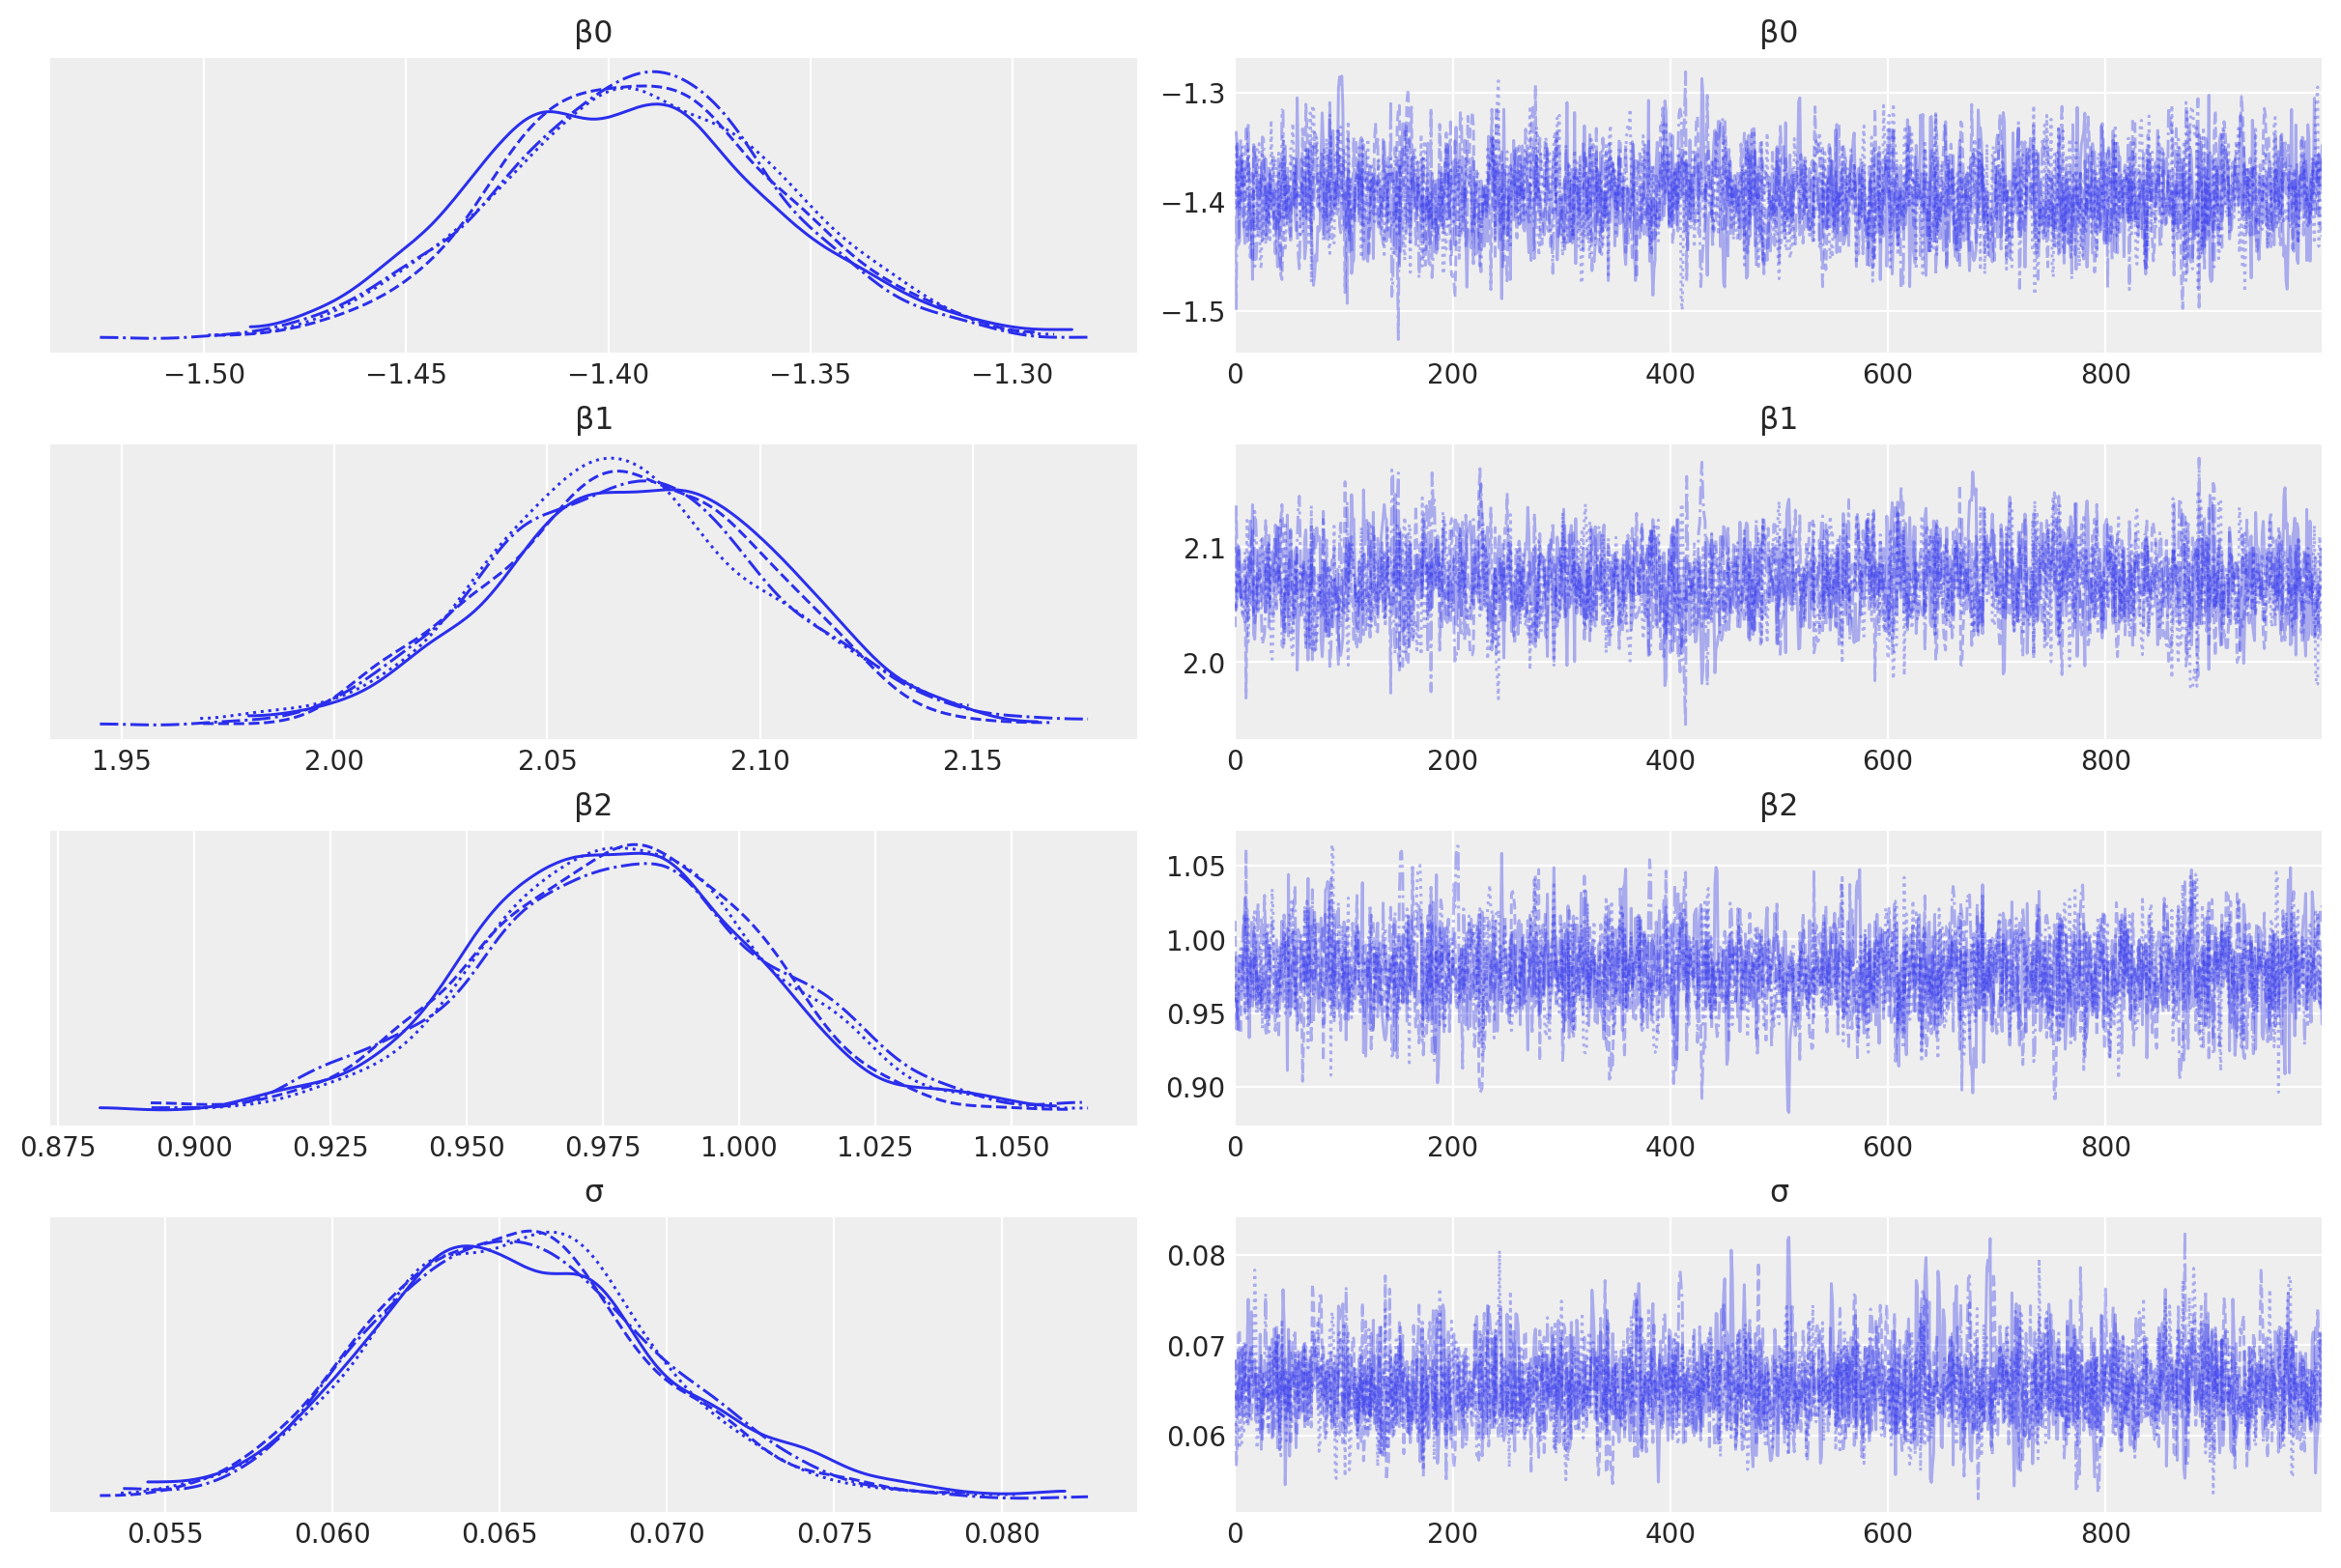

In [148]:
az.plot_trace(idata)

In [150]:
with model:
    prior_samples = pm.sample_prior_predictive(1000)

Sampling: [Weight_pred, β0, β1, β2, σ]


In [151]:
y_pred = idata.predictions["Weight_pred"].mean(dim=["chain", "draw"]).data

R2, RMSE = r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False)

print(R2, RMSE)

AttributeError: 'InferenceData' object has no attribute 'predictions'

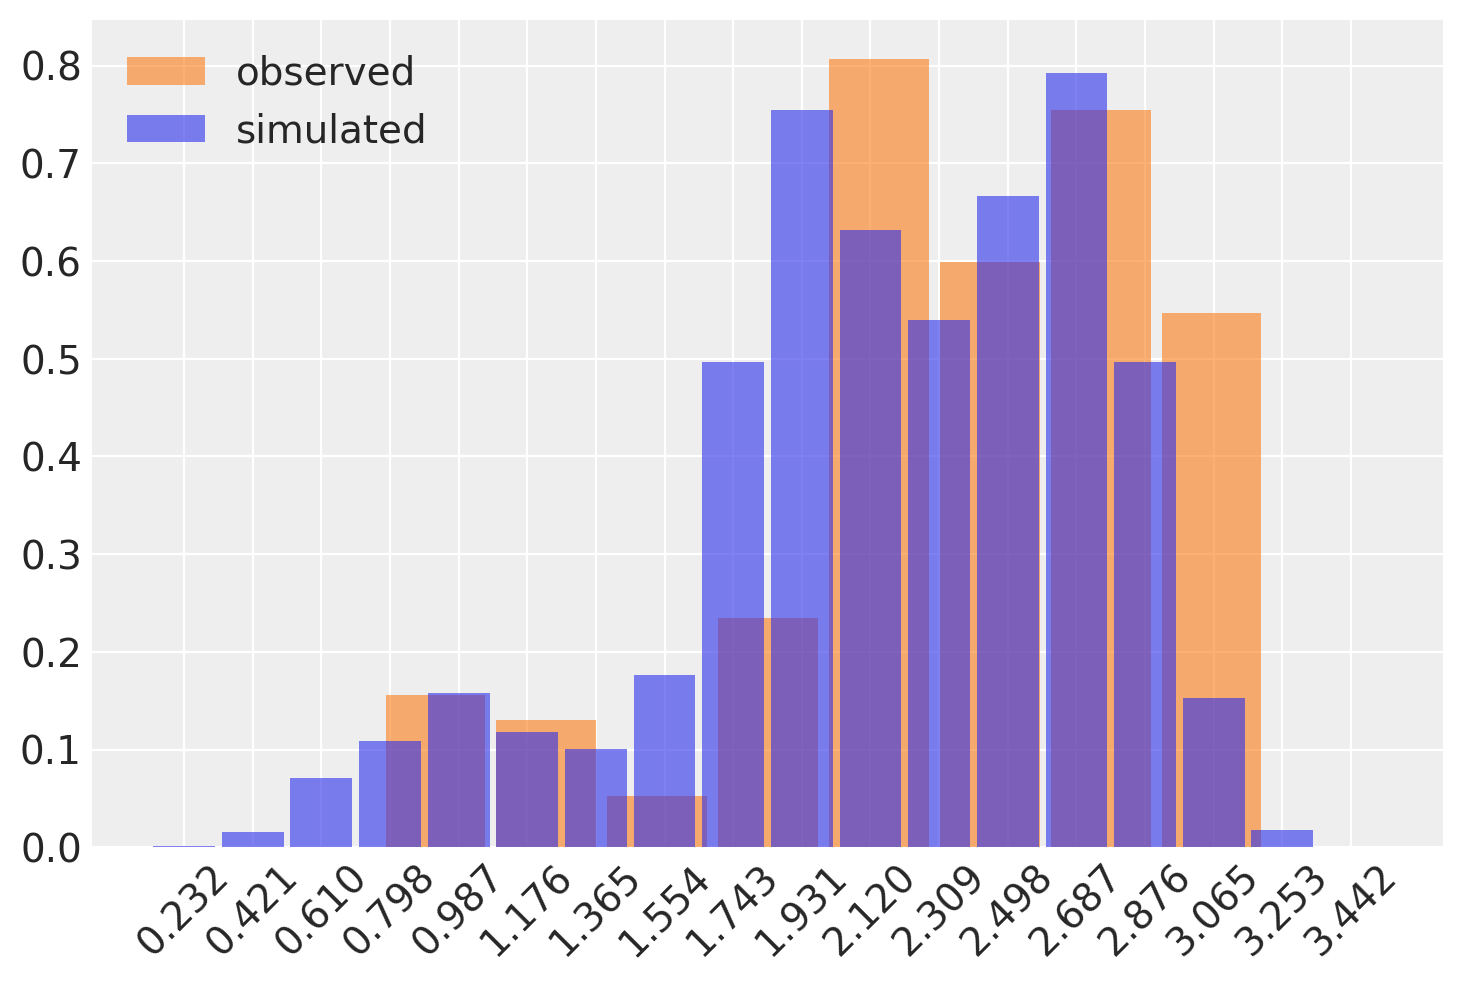

In [153]:
az.plot_dist(
    y_train["Weight"].values,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["Weight_pred"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);

In [124]:
with model:
    pm.set_data({"Height":  X_test['Height'].to_numpy()})
    pm.set_data({"Length1":  X_test['Length1'].to_numpy()})

    pm.sample_posterior_predictive(
        idata,
        predictions=True,
        extend_inferencedata=True,
        random_seed=42,
    )

y_pred = idata.predictions["Weight_pred"].mean(dim=["chain", "draw"]).data

R2, RMSE = r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False)

print(R2, RMSE)

Sampling: [Weight_pred]


TypeError: Concatenating overlapping groups is not supported unless `dim` is defined. Valid dimensions are `chain` and `draw`. Alternatively, use extend to combine InferenceData with overlapping groups